In [4]:
#installs:
#!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets sentencepiece
!pip install -q pytorch-lightning wandb

In [5]:
#imports:
import os
from datasets import load_dataset
from PIL import Image

In [6]:
os.environ["HF_TOKEN"] = ""
dataset = load_dataset("Resi/donut_dokumenttyp_classification_2560_1920")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'ground_truth'],
        num_rows: 1253
    })
    test: Dataset({
        features: ['image', 'label', 'ground_truth'],
        num_rows: 66
    })
})

In [8]:
print(dataset['train'].features)

{'image': Image(mode=None, decode=True, id=None), 'label': Value(dtype='string', id=None), 'ground_truth': {'gt_parse': {'class': Value(dtype='string', id=None)}}}


In [9]:
Image.MAX_IMAGE_PIXELS = None
unique_labels = set([example['label'] for example in dataset['train']])
label2id = {label: idx for idx, label in enumerate(unique_labels)}
label2id

{'Richtlinien': 0,
 'Bausatzzeichnung': 1,
 'Lageplan': 2,
 'Phasenführungsplan Ist_Soll': 3,
 'Mastfußausbildung': 4,
 'Provisorium - Planung': 5,
 'Übersichtsplan 1%3A25000': 6,
 'Längenprofil Vollausbauplanung (IHL)': 7,
 'Prüfstatik': 8,
 'Lageplan 1%3A2500 (IHL)': 9,
 'Abankerungsskizze': 10,
 'Längenprofil Realisierungsstand (IHL)': 11,
 'Bauablaufplan': 12,
 'Systemzeichnung': 13,
 'Maststandortskizzen ': 14,
 'Stücklisten': 15,
 'Baustelleneinrichtung - Beschreibung': 16,
 'Baumastliste': 17,
 'Masttypenbild': 18,
 'Maststatik': 19,
 'Werkstattzeichnung': 20,
 'Baugrunduntersuchung Baugrundgutachten ': 21,
 'Diagonalprofil mit Schrägfußecken und Fundamente ': 22,
 'Ergebniszusammenstellung': 23,
 'Lageplan_Sonderplan': 24,
 'Naturschutz': 25,
 'Erdungsanlagenaufmaß': 26,
 'Provisorium - Arbeitsbeschreibung': 27,
 'Hydrologische Gutachten': 28,
 'Prüfbericht Bausätze_Ketten': 29,
 'Abstandsnachweisprotokoll': 30,
 'Bautagebuch': 31,
 'Reguliertabelle': 32,
 'Fundamentzeichnung':

In [10]:
example = dataset['train'][0]
example['ground_truth']

{'gt_parse': {'class': 'Werkstattzeichnung'}}

In [11]:
from ast import literal_eval

if isinstance(example["ground_truth"], str):
    gt_parse = literal_eval(example["ground_truth"])['gt_parse']
else:
    gt_parse = example["ground_truth"]['gt_parse']

gt_parse

{'class': 'Werkstattzeichnung'}

## Load Model and Processor:

In [12]:
from transformers import VisionEncoderDecoderConfig

max_length = 8
image_size = [1280, 960]#[2560, 1920]

config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base") #"naver-clova-ix/donut-base"
config.encoder.image_size = image_size # (height, width)
config.decoder.max_length = max_length

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)

In [14]:
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/models/donut/processing_donut.py:192: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [15]:
len(processor.tokenizer)

57525

In [16]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [17]:
additional_tokens = [
    '<Umweltverträglichkeitsuntersuchung/>',
    '<Provisorium - Planung/>',
    '<Richtlinien/>',
    '<Lageplan 1%3A2500 (IHL)/>',
    '<Provisorium - Arbeitsbeschreibung/>',
    '<Abankerungsskizze/>',
    '<Maststandortskizzen/>',
    '<Phasenführungsplan Ist_Soll/>',
    '<Mastfußausbildung/>',
    '<Systemzeichnung/>',
    '<Längenprofil Vollausbauplanung/>',
    '<Bausatzzeichnung/>',
    '<Prüfstatik/>',
    '<Abstandsnachweisprotokoll/>',
    '<Längenprofil Vollausbauplanung (IHL)/>',
    '<Wasserrechtliche Genehmigung/>',
    '<Fundamentzeichnung/>',
    '<Längenprofil Realisierungsstand/>',
    '<Fundamentstatik/>',
    '<Bauablaufplan/>',
    '<Baugrunduntersuchung Baugrundgutachten/>',
    '<Übersichtsplan 1%3A25000/>',
    '<Baustelleneinrichtung - Beschreibung/>',
    '<Stücklisten/>',
    '<Masttypenbild/>',
    '<Bautagebuch/>',
    '<Baumastliste/>',
    '<Werkstattzeichnung/>',
    '<Lageplan_Sonderplan/>',
    '<Maststatik/>',
    '<Hydrologische Gutachten/>',
    '<Ergebniszusammenstellung/>',
    '<Reguliertabelle/>',
    '<Lageplan/>',
    '<Prüfbericht Bausätze_Ketten/>',
    '<Naturschutz/>',
    '<Fundamentliste/>',
    '<Erdungsanlagenaufmaß/>',
    '<Kreuzungsverzeichnis/>',
    '<Längenprofil Realisierungsstand (IHL)/>',
    '<Diagonalprofil mit Schrägfußecken und Fundamente/>'
]
add_tokens(additional_tokens)

In [18]:
processor.tokenizer.convert_tokens_to_ids(["<Kreuzungsverzeichnis/>"])

[57563]

In [19]:
len(processor.tokenizer)

57566

In [20]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = sample["ground_truth"]
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"<s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in additional_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # pixel values (we remove the batch dimension)
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # labels, which are the input ids of the target sequence
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)

        encoding = dict(pixel_values=pixel_values,
                        labels=labels)

        return encoding

In [21]:
train_dataset = DonutDataset("Resi/donut_dokumenttyp_classification_2560_1920", max_length=max_length,
                             split="train", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, # rvlcdip dataset is preprocessed, so no need for this
                             )

In [22]:
train_dataset[4]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor([57566, 57544, 42990, 40598, 46192, 41403, 48461

## Create PyTorch DataLoader

In [23]:
from torch.utils.data import DataLoader

# I'm using a small batch size to make sure it fits in the memory Colab provides
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [24]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['pixel_values', 'labels'])


In [25]:
for id in batch['labels'][0].tolist():
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_class>
<Bautagebuch/>

</
s
_
class
>


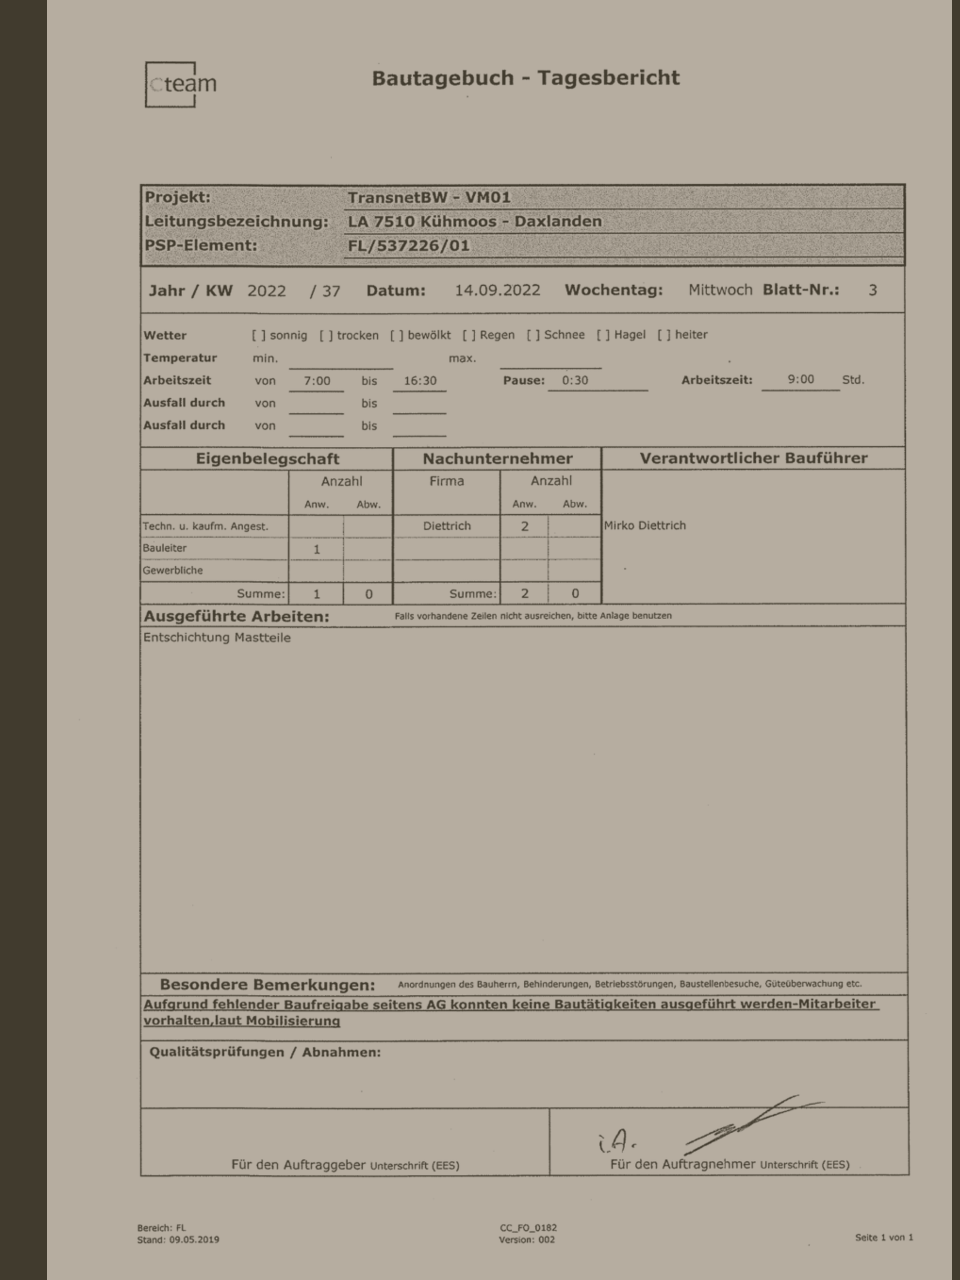

In [26]:
from PIL import Image
import numpy as np

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# unnormalize
reconstructed_image = (batch['pixel_values'][0] * torch.tensor(std)[:, None, None]) + torch.tensor(mean)[:, None, None]
# unrescale
reconstructed_image = reconstructed_image * 255
# convert to numpy of shape HWC
reconstructed_image = torch.moveaxis(reconstructed_image, 0, -1)
image = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
image

In [27]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_rvlcdip>'])[0]

In [28]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_rvlcdip>


In [29]:
import torch
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

for epoch in range(15):
    print("Epoch:", epoch+1)
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = model(pixel_values=pixel_values,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print("Loss:", loss.item())

Epoch: 1


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 19.640932083129883
Loss: 2.851534366607666
Loss: 1.9587829113006592
Loss: 1.432856798171997
Loss: 1.1920500993728638
Loss: 1.1396143436431885
Loss: 0.2135256677865982
Loss: 0.5596649050712585
Loss: 1.0192086696624756
Loss: 0.4411909878253937
Loss: 0.6510828137397766
Loss: 0.1589675098657608
Loss: 0.11909136921167374
Epoch: 2


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.6794530153274536
Loss: 0.04674052074551582
Loss: 0.7377080917358398
Loss: 0.23006434738636017
Loss: 0.07923796772956848
Loss: 0.7377527356147766
Loss: 1.3669979572296143
Loss: 0.17186088860034943
Loss: 0.3599308729171753
Loss: 0.1327858865261078
Loss: 0.317061185836792
Loss: 0.07700376957654953
Loss: 0.05361674353480339
Epoch: 3


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.42261257767677307
Loss: 0.025402415543794632
Loss: 0.002154129557311535
Loss: 0.005082804709672928
Loss: 0.0014751376584172249
Loss: 0.12915511429309845
Loss: 0.5220983028411865
Loss: 0.11948537081480026
Loss: 0.02003137394785881
Loss: 0.3058132529258728
Loss: 0.009098748676478863
Loss: 0.47739073634147644
Loss: 0.006740778684616089
Epoch: 4


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.006400732323527336
Loss: 0.045311667025089264
Loss: 0.17075109481811523
Loss: 0.4135887622833252
Loss: 0.639800488948822
Loss: 0.21319009363651276
Loss: 0.02536873146891594
Loss: 0.0019254301441833377
Loss: 0.1968185156583786
Loss: 0.0012710775481536984
Loss: 0.3335479497909546
Loss: 0.0003112783015239984
Loss: 0.31705036759376526
Epoch: 5


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.003249292029067874
Loss: 0.0014920635148882866
Loss: 0.00027473430964164436
Loss: 0.007476487662643194
Loss: 0.0005845186533406377
Loss: 0.07265864312648773
Loss: 0.0012295388150960207
Loss: 0.3628966212272644
Loss: 0.4806431829929352
Loss: 0.002290114061906934
Loss: 0.04369579628109932
Loss: 0.013008897192776203
Loss: 0.00043791215284727514
Epoch: 6


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.3997989296913147
Loss: 0.07693187892436981
Loss: 0.0005093800136819482
Loss: 0.0034804181195795536
Loss: 0.0009463310125283897
Loss: 0.09741850197315216
Loss: 0.10982044041156769
Loss: 0.0003008945204783231
Loss: 0.00023751051048748195
Loss: 5.886994767934084e-05
Loss: 0.0006176629685796797
Loss: 0.011442091315984726
Loss: 0.007738414686173201
Epoch: 7


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.02363586239516735
Loss: 0.11831599473953247
Loss: 0.0004793482949025929
Loss: 0.5603843927383423
Loss: 0.03593705967068672
Loss: 0.00018301485397387296
Loss: 0.3558501601219177
Loss: 0.0012239462230354548
Loss: 0.0010612152982503176
Loss: 9.875898103928193e-05
Loss: 5.96367972320877e-05
Loss: 0.18540342152118683
Loss: 0.007767610251903534
Epoch: 8


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.004665234591811895
Loss: 0.002272692508995533
Loss: 0.0007072761654853821
Loss: 0.0327366478741169
Loss: 0.007230822462588549
Loss: 0.006309670861810446
Loss: 0.12882684171199799
Loss: 0.3963696360588074
Loss: 0.043485209345817566
Loss: 3.347908568684943e-05
Loss: 0.0007266290485858917
Loss: 0.13987939059734344
Loss: 0.006918559316545725
Epoch: 9


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.4292275905609131
Loss: 0.2831815779209137
Loss: 0.002705605234950781
Loss: 0.0026444015093147755
Loss: 0.022176118567585945
Loss: 0.001104988856241107
Loss: 0.0011959041003137827
Loss: 0.003062874311581254
Loss: 0.0005167771596461535
Loss: 0.0014171648072078824
Loss: 0.0023611560463905334
Loss: 0.0005220439052209258
Loss: 0.4876016676425934
Epoch: 10


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.00018084851035382599
Loss: 6.549808313138783e-05
Loss: 5.663428601110354e-05
Loss: 7.420606380037498e-06
Loss: 0.0005921201081946492
Loss: 0.0031260643154382706
Loss: 7.106982229743153e-05
Loss: 0.008652815595269203
Loss: 0.3274102509021759
Loss: 0.07960066199302673
Loss: 0.07668005675077438
Loss: 0.0005021116230636835
Loss: 0.0004233247018419206
Epoch: 11


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.0004636879311874509
Loss: 5.19959612574894e-05
Loss: 0.00010461118654347956
Loss: 0.0074601187370717525
Loss: 7.371284300461411e-05
Loss: 0.00015299768710974604
Loss: 1.5556444850517437e-05
Loss: 6.536344881169498e-05
Loss: 0.00020699479500763118
Loss: 0.07171507179737091
Loss: 1.3753081475442741e-05
Loss: 0.04148745909333229
Loss: 0.17840571701526642
Epoch: 12


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.0003197319165337831
Loss: 0.0001675864914432168
Loss: 0.020318539813160896
Loss: 0.001053844578564167
Loss: 0.005423218011856079
Loss: 0.006462822202593088
Loss: 4.331147647462785e-05
Loss: 0.0010963071836158633
Loss: 2.083098479488399e-05
Loss: 3.730701428139582e-05
Loss: 0.0016762660816311836
Loss: 0.002191430190578103
Loss: 2.2856687792227603e-05
Epoch: 13


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 0.007771825417876244
Loss: 0.0208310354501009
Loss: 0.011593342758715153
Loss: 0.0028201332315802574
Loss: 2.1606531390716555e-06
Loss: 0.0002294766018167138
Loss: 0.06985574960708618
Loss: 1.0698854566726368e-05
Loss: 0.0004117780481465161
Loss: 0.0008620115695521235
Loss: 5.5485717894043773e-05
Loss: 0.012431365437805653
Loss: 0.0065816547721624374
Epoch: 14


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 7.391896360786632e-05
Loss: 2.2692460333928466e-05
Loss: 0.0071457079611718655
Loss: 0.002526943339034915
Loss: 0.00016364183102268726
Loss: 0.015963509678840637
Loss: 0.00013272545766085386
Loss: 0.8380973935127258
Loss: 0.00038707387284375727
Loss: 3.4135289752157405e-05
Loss: 0.0001725561305647716
Loss: 0.0005904901772737503
Loss: 0.010992463678121567
Epoch: 15


  0%|          | 0/1253 [00:00<?, ?it/s]

Loss: 1.947434247995261e-05
Loss: 5.0198133976664394e-05
Loss: 0.0001245269231731072
Loss: 0.030048126354813576
Loss: 0.0008627038914710283
Loss: 0.001695302315056324
Loss: 0.0002858084917534143
Loss: 0.00011299559992039576
Loss: 0.0002244650386273861
Loss: 0.0007204544963315129
Loss: 1.0058168300020043e-05
Loss: 0.00012942553439643234
Loss: 0.00010838100570254028


In [30]:
repo_name = "Resi/finetune-donut-doctype-sagemaker"

# here we push the processor and model to the hub
# note that you can add `private=True` in case you're using the private hub
# which makes sure the model is only shared with your colleagues

model.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Resi/finetune-donut-doctype-sagemaker/commit/42460c30b1e9884431ed832f709ea938a15c3caa', commit_message='Upload model', commit_description='', oid='42460c30b1e9884431ed832f709ea938a15c3caa', pr_url=None, pr_revision=None, pr_num=None)

In [31]:
processor.push_to_hub(repo_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Resi/finetune-donut-doctype-sagemaker/commit/1fa35fcf6648e8629b684d48013a4bc4e5d3ef08', commit_message='Upload processor', commit_description='', oid='1fa35fcf6648e8629b684d48013a4bc4e5d3ef08', pr_url=None, pr_revision=None, pr_num=None)

## Inference:

In [30]:
import os
os.environ["HF_TOKEN"] = ""
from transformers import DonutProcessor, VisionEncoderDecoderModel

# #processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip")
#model = VisionEncoderDecoderModel.from_pretrained("Resi/donut_dokumenttyp_colab")

In [32]:
import re
import json
import numpy as np
from tqdm import tqdm

# Ensure the model is on the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# Load your dataset
dataset = load_dataset("Resi/donut_dokumenttyp_classification_2560_1920", split="test")

output_list = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = sample["ground_truth"]
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)

    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")


  0%|          | 0/66 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 66/66 [07:31<00:00,  6.84s/it]

{'accuracies': [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], 'mean_accuracy': 0.8333333333333334} length : 66


In [45]:
num = 6
image = dataset[num]['image']
dataset[num]['ground_truth']

{'gt_parse': {'class': 'Prüfstatik'}}

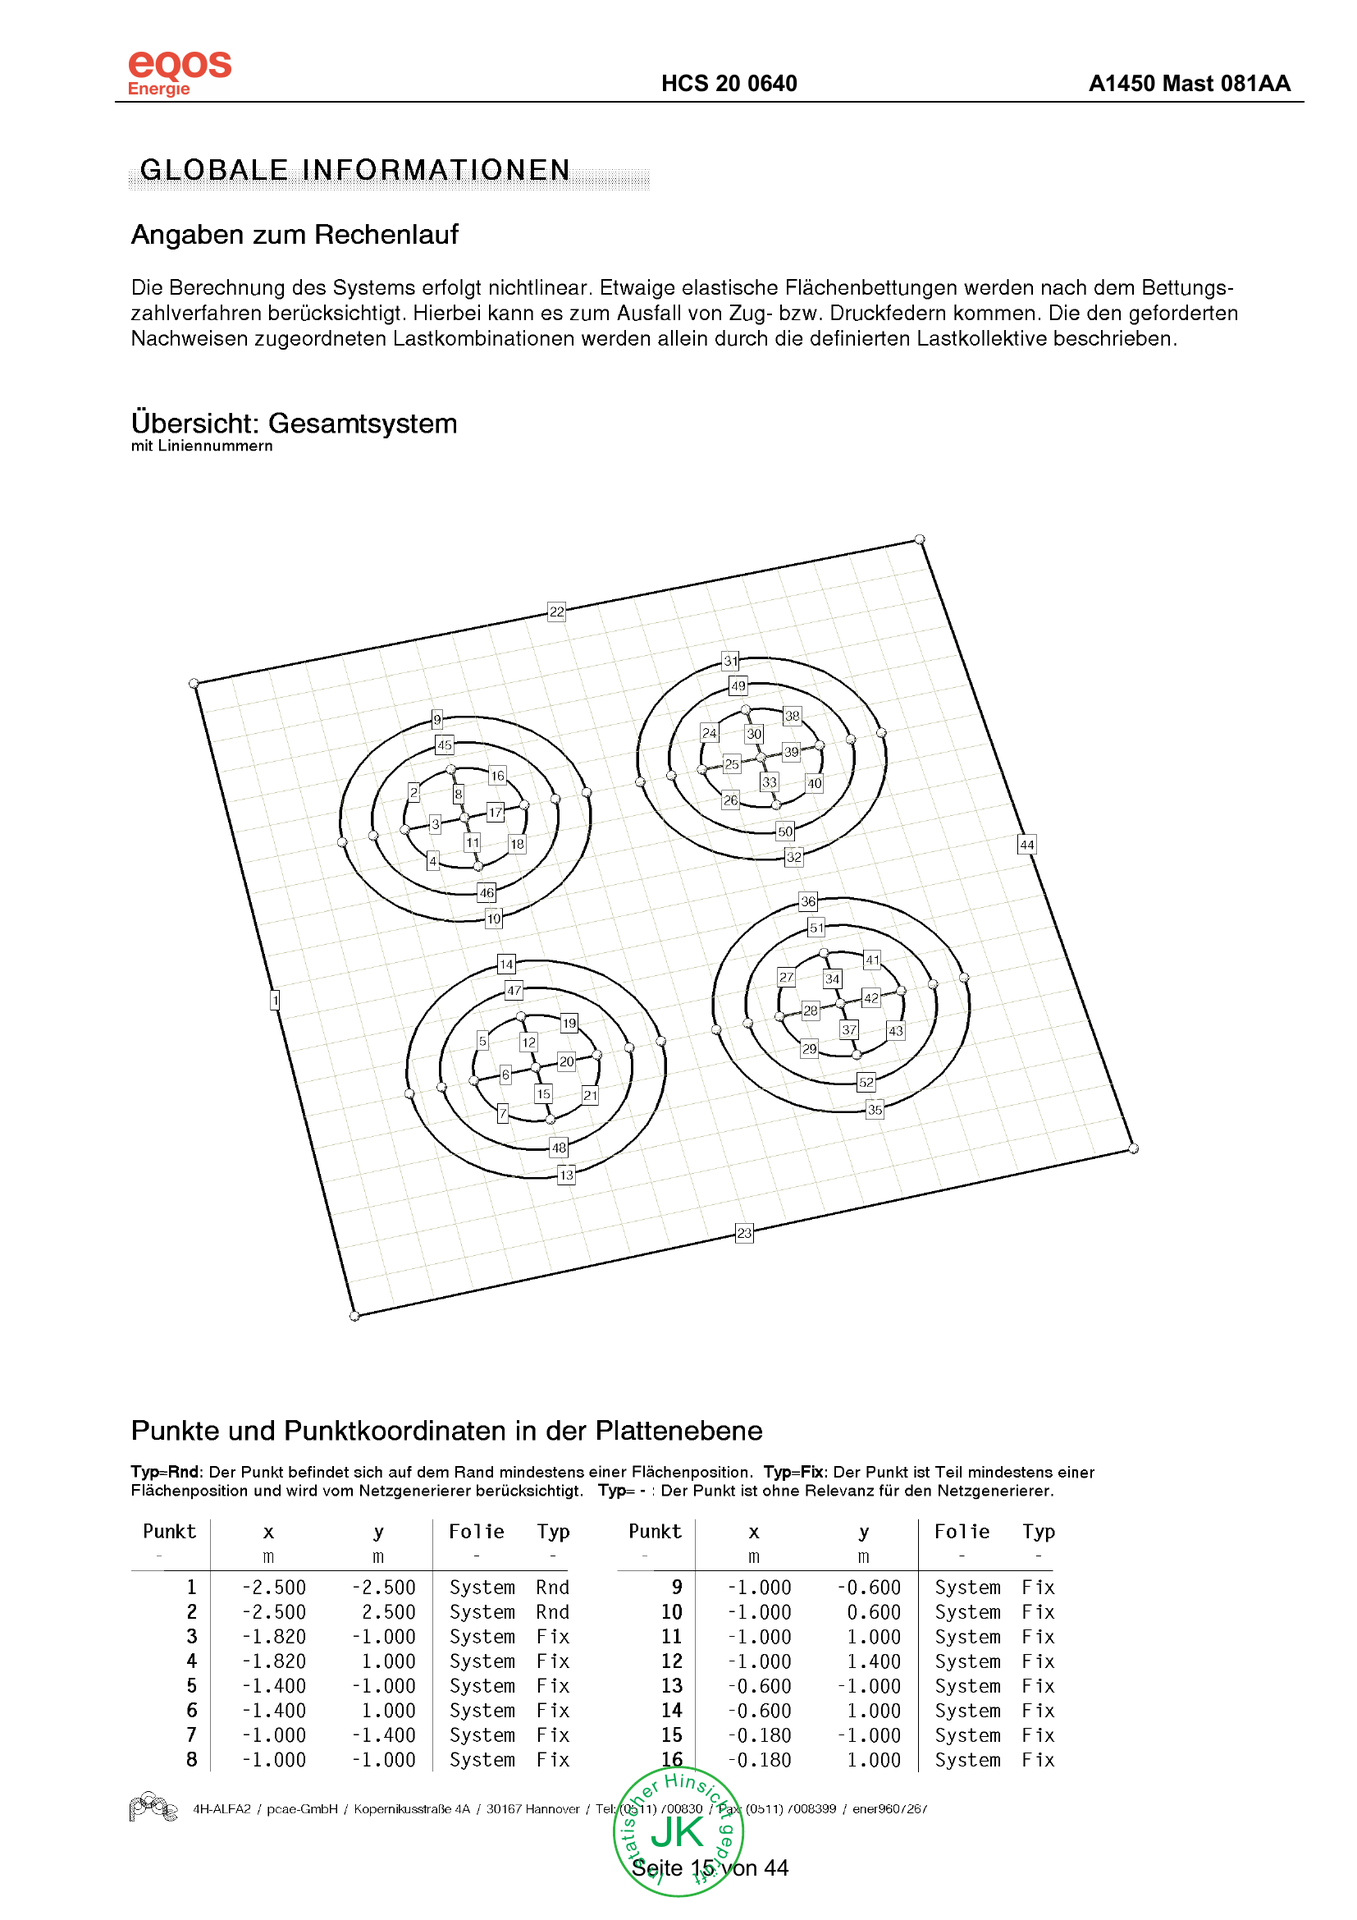

In [46]:
image

In [47]:
# image_path = r'C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\resized_pngs_1280_960\2899-MR-420b_page_1.png'
# image_path = './2899-MR-420b_page_1.png'
# image_path = './1450_M2208A_Baugrunduntersuchung_page_2.png'
# image = Image.open(image_path)

pixel_values = processor(image.convert("RGB"), return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)
# prepare decoder inputs
task_prompt = "<s_rvlcdip>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
decoder_input_ids = decoder_input_ids.to(device)

# autoregressively generate sequence
outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

# turn into JSON
seq = processor.batch_decode(outputs.sequences)[0]
seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
seq = processor.token2json(seq)
print(seq)

{'class': 'Prüfstatik'}
